In [1]:
!ls

batch_jobs			   README.md
downstream_moco_experiment.py	   Resnet_downstream_experiment.py
dp_moco_experiment2.py		   Resnet_experiment.py
dp_moco_experiment.py		   saved_models
Explore_Data.ipynb		   src
hi-res-test_resnet.py		   SwinT_experiment.py
imagenette_experiment.ipynb	   test_downstream_dataset.py
imagenette_experiment-SwinT.ipynb  test_torch.py
imagenette_resnet.py		   wandb
moco_experiment.py


In [2]:
import numpy as np
import pandas as pd
import torch
import torchvision
from tqdm.notebook import tqdm
import glob
import re

from src.data_stuff import dataset_tools


import matplotlib.pyplot as plt

print('CUDA available:', torch.cuda.is_available())

CUDA available: True


In [3]:
!ls /tcmldrive/databases/Public/TCGA/data/
!echo ---
!ls /tcmldrive/databases/Public/TCGA/data/train

clinical_Atlas.csv  data_table_Colorectal_Adenocarcinoma.csv  STAD  test  train
---
MSIMUT	MSS


# ∅ Dataset

In [4]:
ROOT_DIR = '/tcmldrive/databases/Public/TCGA/data/'
TRAIN_DIR = ROOT_DIR + 'train'
TEST_DIR = ROOT_DIR + 'test'

class params:
    bs = 5

# rgb_mean = (0.4914, 0.4822, 0.4465)
# rgb_std = (0.2023, 0.1994, 0.2010)

train_tfms = torchvision.transforms.Compose([
#     torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(rgb_mean, rgb_std),
])

In [5]:
train_ds = dataset_tools.ImageFolderWithPaths(TRAIN_DIR, train_tfms)
test_ds = dataset_tools.ImageFolderWithPaths(TEST_DIR, train_tfms)

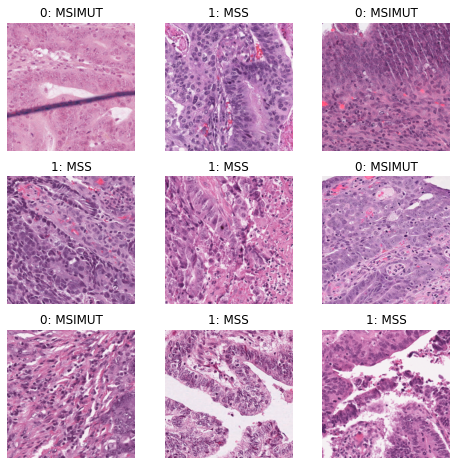

In [6]:
labels_map = {
    0: "MSIMUT",
    1: "MSS",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_ds), size=(1,)).item()
    path, img, label = train_ds[sample_idx]
    img = img.permute(1, 2, 0)    
    figure.add_subplot(rows, cols, i)
    plt.title(f'{label}: {labels_map[label]}')
    plt.axis("off")
    plt.imshow(img)
plt.show()

# 🚛 Dataloader

In [7]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=params.bs, num_workers=4, shuffle=True)

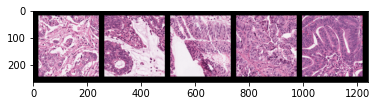

In [8]:
# images = torch.rand(4, 3, 255, 255)
images = next(iter(train_dl))[1]
plt.imshow(torchvision.utils.make_grid(images, padding=20).permute(1, 2, 0))

# 📊 Explore

In [9]:
print(f'Classes: {train_ds.classes}')
print(f'Train Len: {len(train_ds)} | Test Len: {len(test_ds)}')

Classes: ['MSIMUT', 'MSS']
Train Len: 93408 | Test Len: 98904


In [10]:
len_MSIMUT_train = np.sum(np.array(train_ds.targets) == 1)
len_MSS_train = np.sum(np.array(train_ds.targets) == 0)
len_MSIMUT_test = np.sum(np.array(test_ds.targets) == 1)
len_MSS_test = np.sum(np.array(test_ds.targets) == 0)

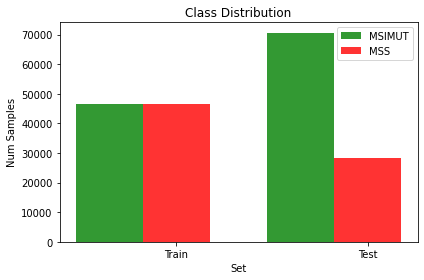

In [11]:
# data to plot
n_groups = 2
MSIMUT_lens = (len_MSIMUT_train, len_MSIMUT_test)
MSS_lens = (len_MSS_train, len_MSS_test)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, MSIMUT_lens, bar_width, alpha=opacity, color='g', label='MSIMUT')

rects2 = plt.bar(index + bar_width, MSS_lens, bar_width, alpha=opacity, color='r', label='MSS')

plt.xlabel('Set')
plt.ylabel('Num Samples')
plt.title('Class Distribution')
plt.xticks(index + bar_width, ('Train', 'Test'))
plt.legend()

plt.tight_layout()
plt.show()

# ䷀ Tabular Data

In [12]:
clinical_atlas_path = ROOT_DIR + 'clinical_Atlas.csv'
data_table_colorectal_adenocarcinoma_path = ROOT_DIR + 'data_table_Colorectal_Adenocarcinoma.csv'

atlas_df = pd.read_csv(clinical_atlas_path)
aden_df = pd.read_csv(data_table_colorectal_adenocarcinoma_path)

In [13]:
atlas_df

,Unnamed: 0,TCGA Participant Barcode,TCGA Project Code,Organ,Pathologic T,Pathologic N,Pathologic M,Pathologic Stage,Country,Gender,...,arm_CN_17p,arm_CN_17q,arm_CN_18p,arm_CN_18q,arm_CN_19p,arm_CN_19q,arm_CN_20p,arm_CN_20q,arm_CN_21q,arm_CN_22q\n
0,0,TCGA-2H-A9GF,ESCA,Esophageal,T3,N1,M0,III,Netherlands,MALE,...,-0.214,0.475,-0.561,-0.561,-0.688,-0.688,0.529,0.529,-0.638,0.000
1,1,TCGA-2H-A9GH,ESCA,Esophageal,T1,N1,M0,IIB,Netherlands,MALE,...,0.000,0.000,0.000,-0.428,-0.396,-0.396,0.318,0.318,0.000,-0.434
2,2,TCGA-2H-A9GI,ESCA,Esophageal,T3,N1,M0,III,Netherlands,MALE,...,0.000,0.000,-1.313,-0.615,-0.434,-0.434,-0.517,0.911,0.000,-0.627
3,3,TCGA-2H-A9GK,ESCA,Esophageal,T3,N1,M0,III,Netherlands,MALE,...,-0.747,0.000,0.382,0.382,-0.392,0.529,0.000,0.000,-0.626,-0.351
4,4,TCGA-2H-A9GL,ESCA,Esophageal,T3,N1,M0,III,Netherlands,MALE,...,-0.632,0.000,-0.410,0.000,0.000,0.000,2.358,0.000,-0.622,-0.311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,916,TCGA-WS-AB45,COAD,COAD,T3,N0,MX,IIA,United_States,FEMALE,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
917,917,TCGA-X8-AAAR,ESCA,Esophageal,T1,N1,NaN,NaN,United_States,MALE,...,-0.760,-0.745,-0.660,-0.660,0.000,0.000,0.000,0.000,0.000,0.000
918,918,TCGA-ZA-A8F6,STAD,Gastric,T2,N0,MX,IB,United_States,MALE,...,0.000,0.000,0.000,0.000,0.000,0.000,0.892,0.892,0.000,0.000
919,919,TCGA-ZQ-A9CR,STAD,Gastric,T4a,N3,MX,IIIC,United_Kingdom,FEMALE,...,-0.395,-0.395,0.902,-0.475,-0.381,-0.381,2.002,2.002,-0.401,-0.446


In [14]:
aden_df

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,patient,SNP,DEL,CNV_Fraction_DEL,Molecular_Subtype
0,0,0,0,TCGA-3L-AA1B,182.0,2.0,0.033639,CIN
1,1,1,1,TCGA-4N-A93T,145.0,5.0,0.200816,CIN
2,2,2,2,TCGA-4T-AA8H,181.0,4.0,0.024198,CIN
3,3,3,3,TCGA-5M-AAT4,258.0,6.0,0.124080,CIN
4,4,4,4,TCGA-5M-AAT6,2542.0,360.0,0.013112,MSI
...,...,...,...,...,...,...,...,...
589,589,589,589,TCGA-F5-6814,13443.0,7.0,0.003471,HM-SNV
590,590,590,590,TCGA-F5-6861,131.0,3.0,0.000009,GS
591,591,591,591,TCGA-F5-6863,103.0,0.0,0.086308,CIN
592,592,592,592,TCGA-F5-6864,191.0,5.0,0.109195,CIN


### Get all patients

In [15]:
# we only use patients that have COAD & READ Project Code
atlas_df = atlas_df[atlas_df['TCGA Project Code'].isin(["COAD", "READ"])]

In [16]:
patient_list = list(atlas_df["TCGA Participant Barcode"])

In [17]:
## Each row is a unique patient
len(set(patient_list)) == len(patient_list)

True

In [18]:
len(patient_list)

459

In [19]:
patient_list[:10]

['TCGA-3L-AA1B',
 'TCGA-4N-A93T',
 'TCGA-4T-AA8H',
 'TCGA-5M-AAT4',
 'TCGA-5M-AAT5',
 'TCGA-5M-AAT6',
 'TCGA-5M-AATA',
 'TCGA-5M-AATE',
 'TCGA-A6-2671',
 'TCGA-A6-2675']

### Get all file names

In [44]:
train_img_filenames_MSIMUT = glob.glob(TRAIN_DIR+'/MSIMUT/*.png')
train_img_filenames_MSS = glob.glob(TRAIN_DIR+'/MSS/*.png')
all_train_filenames = train_img_filenames_MSIMUT + train_img_filenames_MSS

test_img_filenames_MSIMUT = glob.glob(TEST_DIR+'/MSIMUT/*.png')
test_img_filenames_MSS = glob.glob(TEST_DIR+'/MSS/*.png')
all_test_filenames = test_img_filenames_MSIMUT + test_img_filenames_MSS

all_img_filenames = all_test_filenames + all_train_filenames

train_patients_list = [re.findall(r'TCGA-\w{2}-\w{4}', f)[0] for f in all_train_filenames]
test_patients_list = [re.findall(r'TCGA-\w{2}-\w{4}', f)[0] for f in all_test_filenames]

# ensure kosherness
print(f'Train MSIMUT: {len(train_img_filenames_MSIMUT)}')
print(f'Train MSS: {len(train_img_filenames_MSS)}')
print(f'ALL Train: {len(all_train_filenames)}')
print()
print(f'Test MSIMUT: {len(test_img_filenames_MSIMUT)}')
print(f'Test MSS: {len(test_img_filenames_MSS)}')
print(f'ALL Test: {len(all_test_filenames)}')
print()
print(f'ALL Images: {len(all_img_filenames)}')

Train MSIMUT: 46704
Train MSS: 46704
ALL Train: 93408

Test MSIMUT: 28335
Test MSS: 70569
ALL Test: 98904

ALL Images: 192312


In [21]:
len(all_img_filenames) == len(set(all_img_filenames))

True

In [22]:
all_img_filenames[:5]

['/tcmldrive/databases/Public/TCGA/data/test/MSIMUT/blk-AAAFIYHTSVIE-TCGA-G4-6309-01Z-00-DX1.png',
 '/tcmldrive/databases/Public/TCGA/data/test/MSIMUT/blk-AAAITPVFKGLV-TCGA-AZ-6601-01Z-00-DX1.png',
 '/tcmldrive/databases/Public/TCGA/data/test/MSIMUT/blk-AAALIQFQLCHN-TCGA-CK-6747-01Z-00-DX1.png',
 '/tcmldrive/databases/Public/TCGA/data/test/MSIMUT/blk-AAAPDFFDHLSQ-TCGA-AZ-4615-01Z-00-DX1.png',
 '/tcmldrive/databases/Public/TCGA/data/test/MSIMUT/blk-AAAPRACLYGDL-TCGA-AZ-4615-01Z-00-DX1.png']

In [23]:
patient_dict = {}

for p in tqdm(patient_list):
    imgs = [f for f in all_img_filenames if p in f]
    patient_dict[p] = imgs

  0%|          | 0/459 [00:00<?, ?it/s]

In [24]:
num_images_per_patient_list = [len(num) for num in patient_dict.values()]

In [25]:
# THIS IS NOT ALL OF THE IMAGES... (but most of them)
sum(num_images_per_patient_list)

188893

### Which images dont have an associated patient???

In [26]:
# Find all images associated with a patient
associated_imgs = []
for img_list in patient_dict.values():
    for img in img_list:
        associated_imgs.append(img)

# now just get which images are in the set of all filenames but not associated to a patient
stray_imgs = list(set(associated_imgs).symmetric_difference(all_img_filenames))

In [27]:
len(stray_imgs)

3419

### Get the patient IDs

In [28]:
re.findall(r'TCGA-\w{2}-\w{4}', stray_imgs[0])

['TCGA-A6-3809']

In [29]:
stray_patient_ids = [re.findall(r'TCGA-\w{2}-\w{4}', img)[0] for img in stray_imgs]

In [30]:
stray_patient_ids[:5]

['TCGA-A6-3809',
 'TCGA-AZ-6601',
 'TCGA-AZ-6601',
 'TCGA-AZ-6601',
 'TCGA-AA-A022']

In [31]:
set(stray_patient_ids)

{'TCGA-A6-3809', 'TCGA-AA-A00N', 'TCGA-AA-A022', 'TCGA-AZ-6601'}

So we have 4 patients that we have images for, though they are not in the Atlas

Edit: apparently these patients are in data_table_Colorectal_Adenocarcinoma.csv :)

# PLOTS

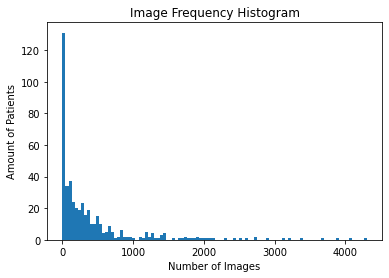

So most of our patients dont have any images.


In [32]:
# Plot Histogram on all patients
plt.hist(num_images_per_patient_list, bins=100)
plt.gca().set(title='Image Frequency Histogram', ylabel='Amount of Patients', xlabel='Number of Images');
plt.show()
print('So most of our patients dont have any images.')

Total Num of Patients with Images: 356 out of 459


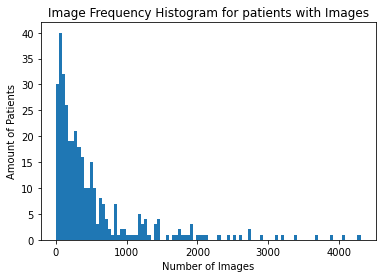

In [33]:
# Get rid of patients w/ no images
num_images_per_patient_list_overZero = [p for p in num_images_per_patient_list if p > 0]
print(f'Total Num of Patients with Images: {len(num_images_per_patient_list_overZero)} out of {len(patient_dict)}')

plt.hist(num_images_per_patient_list_overZero, bins=100)
plt.gca().set(title='Image Frequency Histogram for patients with Images', ylabel='Amount of Patients', xlabel='Number of Images');
plt.show()

  0%|          | 0/459 [00:00<?, ?it/s]

Total Num of Patients with Images (MSIMUT, train+test): 61 out of 356
Total Number of images for MSIMUT Patients: 71620


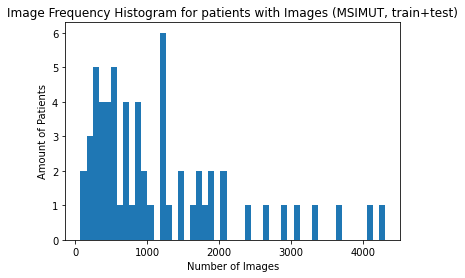

In [34]:
# Get rid of patients w/ no images

patient_dict_MSIMUT = {}

for p in tqdm(patient_list):
    imgs = [f for f in train_img_filenames_MSIMUT + test_img_filenames_MSIMUT if p in f]
    if len(imgs) > 0:
        patient_dict_MSIMUT[p] = imgs

num_images_per_patient_list_MSIMUT = [len(num) for num in patient_dict_MSIMUT.values()]
num_images_per_patient_list_overZero_MSIMUT = [p for p in num_images_per_patient_list_MSIMUT if p > 0]
print(f'Total Num of Patients with Images (MSIMUT, train+test): {len(num_images_per_patient_list_overZero_MSIMUT)} out of {len(num_images_per_patient_list_overZero)}')
print(f'Total Number of images for MSIMUT Patients: {sum(num_images_per_patient_list_MSIMUT)}')

plt.hist(num_images_per_patient_list_overZero_MSIMUT, bins=50)
plt.gca().set(title='Image Frequency Histogram for patients with Images (MSIMUT, train+test)', ylabel='Amount of Patients', xlabel='Number of Images');
plt.show()

  0%|          | 0/459 [00:00<?, ?it/s]

Total Num of Patients with Images (MSS, train+test): 295 out of 356
Total Number of images for MSIMUT Patients: 117273


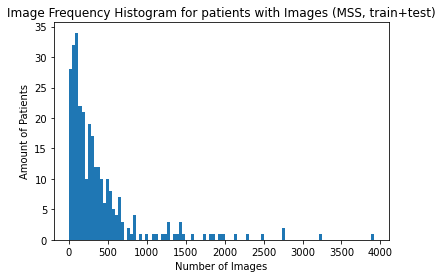

In [35]:
# Get rid of patients w/ no images

patient_dict_MSS = {}

for p in tqdm(patient_list):
    imgs = [f for f in train_img_filenames_MSS + test_img_filenames_MSS if p in f]
    if len(imgs) > 0:
        patient_dict_MSS[p] = imgs

num_images_per_patient_list_MSS = [len(num) for num in patient_dict_MSS.values()]
num_images_per_patient_list_overZero_MSS = [p for p in num_images_per_patient_list_MSS if p > 0]
print(f'Total Num of Patients with Images (MSS, train+test): {len(num_images_per_patient_list_overZero_MSS)} out of {len(num_images_per_patient_list_overZero)}')
print(f'Total Number of images for MSIMUT Patients: {sum(num_images_per_patient_list_MSS)}')

plt.hist(num_images_per_patient_list_overZero_MSS, bins=100)
plt.gca().set(title='Image Frequency Histogram for patients with Images (MSS, train+test)', ylabel='Amount of Patients', xlabel='Number of Images');
plt.show()

# patients with very few samples

In [36]:
patient_patchcount_dict = {k: len(v) for k, v in patient_dict.items()}

In [37]:
patient_patchcount_dict_ordered = {k: v for k, v in sorted(patient_patchcount_dict.items(), key=lambda item: item[1])}
# remove patients with no patches
patient_patchcount_dict_ordered = {k: v for k, v in patient_patchcount_dict_ordered.items() if v != 0}

In [49]:
i = 0
mss = "mss"
msimut = "msimut"

def check_label(patient):
    if patient in list(patient_dict_MSS.keys()):
        return "mss"
    elif patient in list(patient_dict_MSIMUT.keys()):
        return "msimut"
    else:
        return "--- None ---"

def check_set(patient):
    if patient in train_patients_list:
        return "train"
    elif patient in test_patients_list:
        return "test"
    else:
        return "--- None ---"
    
for patient, patch_count in list(patient_patchcount_dict_ordered.items()):
    print(f"{i}:\t {patient}\t {patch_count}\t {check_label(patient)}\t {check_set(patient)}")
    i+=1

0:	 TCGA-D5-6920	 6	 mss	 train
1:	 TCGA-CI-6622	 7	 mss	 train
2:	 TCGA-D5-6898	 7	 mss	 train
3:	 TCGA-AD-6899	 10	 mss	 train
4:	 TCGA-D5-6539	 10	 mss	 train
5:	 TCGA-EI-6917	 10	 mss	 train
6:	 TCGA-D5-6922	 12	 mss	 train
7:	 TCGA-DM-A1D8	 12	 mss	 train
8:	 TCGA-D5-7000	 17	 mss	 train
9:	 TCGA-EI-7004	 17	 mss	 train
10:	 TCGA-CA-6717	 18	 mss	 train
11:	 TCGA-D5-6932	 20	 mss	 train
12:	 TCGA-AD-6963	 23	 mss	 train
13:	 TCGA-D5-6926	 23	 mss	 train
14:	 TCGA-A6-2681	 24	 mss	 train
15:	 TCGA-AG-3727	 27	 mss	 test
16:	 TCGA-AD-6890	 31	 mss	 train
17:	 TCGA-D5-6924	 33	 mss	 train
18:	 TCGA-A6-2671	 35	 mss	 train
19:	 TCGA-AF-6655	 35	 mss	 train
20:	 TCGA-AG-3726	 35	 mss	 test
21:	 TCGA-AA-3858	 36	 mss	 train
22:	 TCGA-CA-5797	 37	 mss	 train
23:	 TCGA-D5-6931	 38	 mss	 train
24:	 TCGA-AG-3890	 40	 mss	 train
25:	 TCGA-AA-3846	 42	 mss	 train
26:	 TCGA-AA-3673	 43	 mss	 train
27:	 TCGA-AH-6547	 43	 mss	 train
28:	 TCGA-AA-3952	 47	 mss	 train
29:	 TCGA-AG-3885	 47	 mss	 t